In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from collections import Counter

from keras.models import Sequential
from keras.layers import Dense, Embedding, Input, Dot, Flatten, LSTM
from keras.regularizers import l2

### Сначала считаем датасеты и посмотрим, какие данные в них представлены

In [3]:
ratings = pd.read_csv('./ratings.csv')
ratings

,userId,movieId,rating,timestamp
0,1,307,3.5,1.256677e+09
1,1,481,3.5,1.256677e+09
2,1,1091,1.5,1.256677e+09
3,1,1257,4.5,1.256677e+09
4,1,1449,4.5,1.256677e+09
...,...,...,...,...
370731,3814,919,5.0,9.426570e+08
370732,3814,920,5.0,9.426566e+08
370733,3814,923,5.0,9.426557e+08
370734,3814,924,5.0,9.426547e+08


In [4]:
tags = pd.read_csv('./tags.csv')
tags

,userId,movieId,tag,timestamp
0,14,110,epic,1.443149e+09
1,14,110,Medieval,1.443149e+09
2,14,260,sci-fi,1.442169e+09
3,14,260,space action,1.442169e+09
4,14,318,imdb top 250,1.442615e+09
...,...,...,...,...
207805,60651,8798,taxi cabs,1.223208e+09
207806,60651,8798,taxi driver,1.223208e+09
207807,60651,8800,To See,1.217827e+09
207808,60651,8810,memasa's movies,1.352895e+09


In [5]:
movies = pd.read_csv('./movies.csv')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


In [6]:
links = pd.read_csv('./links.csv')
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
58093,193876,38566,78251.0
58094,193878,1754787,87558.0
58095,193880,5847740,422666.0
58096,193882,4453756,454439.0


In [7]:
genome_scores = pd.read_csv('./genome-scores.csv')
genome_scores

,movieId,tagId,relevance
0,1,1.0,0.02900
1,1,2.0,0.02375
2,1,3.0,0.05425
3,1,4.0,0.06875
4,1,5.0,0.16000
...,...,...,...
557621,514,390.0,0.11375
557622,514,391.0,0.13950
557623,514,392.0,0.00850
557624,514,393.0,0.10275


In [8]:
genome_tags = pd.read_csv('./genome-tags.csv')
genome_tags

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


### Посмотрим краткую информацию по датасетам, с которыми будем работать впоследствии

#### Начнем с датасета ratings

In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370736 entries, 0 to 370735
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     370736 non-null  int64  
 1   movieId    370736 non-null  int64  
 2   rating     370736 non-null  float64
 3   timestamp  370735 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 11.3 MB


In [10]:
ratings.describe()

,userId,movieId,rating,timestamp
count,370736.000000,370736.000000,370736.000000,3.707350e+05
mean,1845.494028,18852.535292,3.517902,1.190732e+09
std,1066.609012,35898.216314,1.071670,2.160337e+08
min,1.000000,1.000000,0.500000,8.280825e+08
25%,970.000000,1089.000000,3.000000,9.988783e+08
50%,1880.000000,2706.000000,3.500000,1.163629e+09
75%,2715.000000,7149.000000,4.000000,1.418067e+09
max,3814.000000,193861.000000,5.000000,1.537927e+09


In [11]:
ratings.rating.nunique()

10

In [12]:
ratings.rating.value_counts()

4.0    97035
3.0    74187
5.0    53577
3.5    46073
4.5    31978
2.0    25357
2.5    18181
1.0    12594
0.5     5921
1.5     5833
Name: rating, dtype: int64

(array([ 5921., 12594.,  5833., 25357., 18181., 74187., 46073., 97035.,
        31978., 53577.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <BarContainer object of 10 artists>)

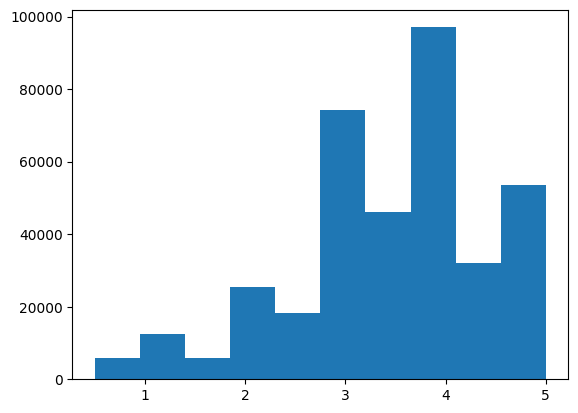

In [13]:
plt.hist(ratings.rating)

Можем сделать вывод, что наиболее частой оценкой является 4.
Также пользователи чаще ставят в качестве рейтинга целые числа, а не дробные.

### Теперь посмотрим на movies

In [14]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [15]:
movies.title.nunique()

58020

In [16]:
movies.title.value_counts()

Slow Burn (2000)                                            2
Blackout (2007)                                             2
20,000 Leagues Under the Sea (1997)                         2
Beneath (2013)                                              2
Deranged (2012)                                             2
                                                           ..
Euridice BA 2O37 (Evridiki BA 2O37) (1975)                  1
Stoplight Society, The (La Sociedad del Semáforo) (2010)    1
Flying Fleet, The (1929)                                    1
Savages (2012)                                              1
Leal (2018)                                                 1
Name: title, Length: 58020, dtype: int64

In [17]:
movies.genres.nunique()

1643

In [18]:
movies.genres.value_counts()

Drama                                      8402
Comedy                                     5372
(no genres listed)                         4266
Documentary                                4250
Comedy|Drama                               2212
                                           ... 
Action|Adventure|Animation|Drama|Sci-Fi       1
Drama|Fantasy|Horror|Mystery|Romance          1
Film-Noir|Thriller|War                        1
Comedy|Musical|Romance|War                    1
Adventure|Animation|Crime                     1
Name: genres, Length: 1643, dtype: int64

То есть, некоторые фильмы повторяются в датасете 2 раза. Определенные комбинации фильмов повторяются достаточно часто, но мы
не можем пока что точно утверждать о частоте использования каждого отдельно жанра. Также 3 по частоте использования место 
занимает '(no genres listed)'. Мы не будем пока предпринимать никаких действий касательно заполнения такого рода пропущенных значений.

#### Посмотрим на tags

In [19]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207810 entries, 0 to 207809
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     207810 non-null  int64  
 1   movieId    207810 non-null  int64  
 2   tag        207810 non-null  object 
 3   timestamp  207809 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 6.3+ MB


In [20]:
tags.describe()

,userId,movieId,timestamp
count,207810.000000,207810.000000,2.078090e+05
mean,31755.823088,48323.102002,1.394210e+09
std,18500.862631,52900.468805,1.118509e+08
min,14.000000,1.000000,1.136317e+09
25%,15181.000000,2761.000000,1.311345e+09
50%,31475.000000,27773.000000,1.438472e+09
75%,47960.000000,88744.000000,1.482011e+09
max,60651.000000,193731.000000,1.537934e+09


In [21]:
tags.tag.nunique()

25458

In [22]:
tags.tag.value_counts()

sci-fi             1870
atmospheric        1471
action             1287
comedy             1101
surreal            1090
                   ... 
ambiguity             1
good actor            1
bad copy              1
Mark Hammill          1
spin the bottle       1
Name: tag, Length: 25458, dtype: int64

Теги не являются уникальными, а некоторые повторяются достаточно часто, что нам пригодится в дальнейшем

#### Перейдем к genome_scores

In [23]:
genome_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557626 entries, 0 to 557625
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    557626 non-null  int64  
 1   tagId      557625 non-null  float64
 2   relevance  557625 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 12.8 MB


In [24]:
genome_scores.describe()

,movieId,tagId,relevance
count,557626.000000,557625.000000,557625.000000
mean,257.915886,564.240995,0.105405
std,148.938974,325.670948,0.142855
min,1.000000,1.000000,0.000750
25%,127.000000,282.000000,0.023000
50%,259.000000,564.000000,0.051750
75%,384.000000,846.000000,0.125750
max,514.000000,1128.000000,1.000000


(array([386609.,  89622.,  36745.,  17557.,  10005.,   5848.,   4034.,
          2960.,   2172.,   2073.]),
 array([7.50000e-04, 1.00675e-01, 2.00600e-01, 3.00525e-01, 4.00450e-01,
        5.00375e-01, 6.00300e-01, 7.00225e-01, 8.00150e-01, 9.00075e-01,
        1.00000e+00]),
 <BarContainer object of 10 artists>)

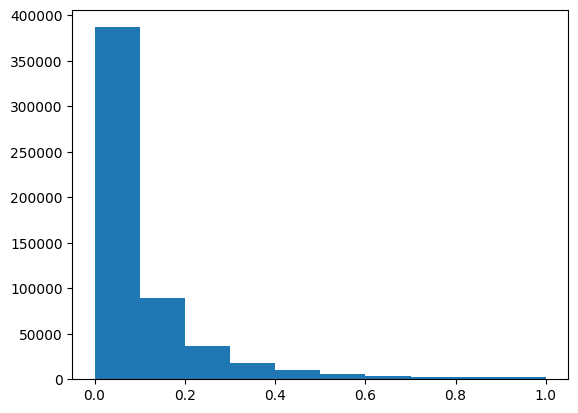

In [25]:
plt.hist(genome_scores.relevance)

Делаем вывод, что большинство пользовательских тегов не являются релевантными 

#### Посмотрим на genome_tags

In [26]:
genome_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


In [28]:
genome_tags.tag.nunique()

1128

In [27]:
genome_tags.tag.value_counts()

007                                    1
oscar (best directing)                 1
oscar (best picture)                   1
oscar (best music - original song)     1
oscar (best music - original score)    1
                                      ..
father daughter relationship           1
father son relationship                1
father-son relationship                1
fbi                                    1
zombies                                1
Name: tag, Length: 1128, dtype: int64

Видим, что все теги являются уникальными

### Поработаем отдельно с датасетом movies
1. Добавим новую колонку 'year' и, соответственно, уберем год выпуска из названия фильма.
2. Преобразуем столбец 'genres' таким образом, чтобы каждый из перечисленных в комбинации жанров был самостоятельно валидным. 

In [29]:
movies_with_year = movies.copy(deep=True)
movies_with_year

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


In [30]:
movies_with_year["year"] = movies_with_year["title"].str.extract(".*\((.*)\).*", expand=False)
movies_with_year

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed),1946
58094,193878,Les tribulations d'une caissière (2011),Comedy,2011
58095,193880,Her Name Was Mumu (2016),Drama,2016
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi,2017


In [31]:
movies_with_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
 3   year     57776 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.8+ MB


In [32]:
movies_with_year[movies_with_year['year'].isna()]

,movieId,title,genres,year
10023,32930,Category 6: Day of Destruction,Action|Drama,NaN
10613,40697,Babylon 5,Sci-Fi,NaN
24089,112406,Brazil: In the Shadow of the Stadiums,Documentary,NaN
24344,113190,Slaying the Badger,Documentary,NaN
24885,115133,Tatort: Im Schmerz geboren,Crime,NaN
...,...,...,...,...
57504,192339,The Sign of Three,(no genres listed),NaN
57674,192829,Parwaaz Hai Junoon,Adventure|Children|Romance,NaN
57789,193149,¿Qué te juegas?,(no genres listed),NaN
57903,193443,Wall,(no genres listed),NaN


In [33]:
movies_with_year['year'] = movies_with_year['year'].fillna(0)

In [34]:
movies_with_year[movies_with_year['year'].isna()]

,movieId,title,genres,year


Так как после отделения года выпуска из названия фильма выяснилось, что не у всех фильмов были указаны годы выпуска, мы получили
и значения NaN, которые затем заполнили нулями.

In [35]:
movies_year_title = movies_with_year.copy(deep=True)
movies_year_title

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed),1946
58094,193878,Les tribulations d'une caissière (2011),Comedy,2011
58095,193880,Her Name Was Mumu (2016),Drama,2016
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi,2017


In [36]:
movies_year_title['title'] = movies_year_title['title'].str.replace('(\(\d\d\d\d\))', '')
movies_year_title

<ipython-input-36-8459579c47d6>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  movies_year_title['title'] = movies_year_title['title'].str.replace('(\(\d\d\d\d\))', '')


,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
...,...,...,...,...
58093,193876,The Great Glinka,(no genres listed),1946
58094,193878,Les tribulations d'une caissière,Comedy,2011
58095,193880,Her Name Was Mumu,Drama,2016
58096,193882,Flora,Adventure|Drama|Horror|Sci-Fi,2017


In [37]:
movies_year_title_genre = movies_year_title.copy(deep=True)
movies_year_title_genre

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
...,...,...,...,...
58093,193876,The Great Glinka,(no genres listed),1946
58094,193878,Les tribulations d'une caissière,Comedy,2011
58095,193880,Her Name Was Mumu,Drama,2016
58096,193882,Flora,Adventure|Drama|Horror|Sci-Fi,2017


In [38]:
movies_year_title_genre['genres'] = movies_year_title_genre['genres'].str.split('|')
movies_year_title_genre

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995
...,...,...,...,...
58093,193876,The Great Glinka,[(no genres listed)],1946
58094,193878,Les tribulations d'une caissière,[Comedy],2011
58095,193880,Her Name Was Mumu,[Drama],2016
58096,193882,Flora,"[Adventure, Drama, Horror, Sci-Fi]",2017


In [39]:
movies_complete = movies_year_title_genre.copy(deep=True)
movies_complete

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995
...,...,...,...,...
58093,193876,The Great Glinka,[(no genres listed)],1946
58094,193878,Les tribulations d'une caissière,[Comedy],2011
58095,193880,Her Name Was Mumu,[Drama],2016
58096,193882,Flora,"[Adventure, Drama, Horror, Sci-Fi]",2017


In [40]:
for i, mc_row in movies_complete.iterrows():
    for genre in mc_row['genres']:
        movies_complete.loc[i, genre] = 1

In [41]:
movies_complete

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,NaN,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Father of the Bride Part II,[Comedy],1995,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58093,193876,The Great Glinka,[(no genres listed)],1946,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
58094,193878,Les tribulations d'une caissière,[Comedy],2011,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58095,193880,Her Name Was Mumu,[Drama],2016,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58096,193882,Flora,"[Adventure, Drama, Horror, Sci-Fi]",2017,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
movies_complete = movies_complete.rename(columns={'(no genres listed)': 'No-Genre'})
movies_complete = movies_complete.fillna(0)
movies_complete

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,No-Genre
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58093,193876,The Great Glinka,[(no genres listed)],1946,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
58094,193878,Les tribulations d'une caissière,[Comedy],2011,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58095,193880,Her Name Was Mumu,[Drama],2016,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58096,193882,Flora,"[Adventure, Drama, Horror, Sci-Fi]",2017,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
train_ds = movies_complete.copy(deep=True)
train_ds = train_ds.drop(['genres'], axis=1)
train_ds

,movieId,title,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,No-Genre
0,1,Toy Story,1995,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,1995,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,1995,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,1995,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,1995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58093,193876,The Great Glinka,1946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
58094,193878,Les tribulations d'une caissière,2011,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58095,193880,Her Name Was Mumu,2016,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58096,193882,Flora,2017,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Сделаем новый датасет, где каждому пользователю соответсвуют оцененные фильмы, отберем некоторое количество наиболее часто повторяющихся и объединим с train_ds

In [44]:
id_user_num = ratings['userId']
id_user_num = id_user_num.drop_duplicates()
id_user_num = id_user_num.tolist();

In [45]:
id_movie_num = movies['movieId']
id_movie_num = id_movie_num.drop_duplicates()
id_movie_num = id_movie_num.tolist();

In [54]:
df = ratings.copy()
df = df.drop(['timestamp'], axis=1)
df

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5
...,...,...,...
370731,3814,919,5.0
370732,3814,920,5.0
370733,3814,923,5.0
370734,3814,924,5.0


In [55]:
map = {k:i for i, k in enumerate(id_user_num)}
df['userId'] = df['userId'].map(map)

In [56]:
map = {k:i for i, k in enumerate(id_movie_num)}
df['movieId'] = df['movieId'].map(map)

In [57]:
df

,userId,movieId,rating
0,0,304,3.5
1,0,477,3.5
2,0,1069,1.5
3,0,1229,4.5
4,0,1414,4.5
...,...,...,...
370731,3813,902,5.0
370732,3813,903,5.0
370733,3813,906,5.0
370734,3813,907,5.0


In [58]:
train_ds_merge = train_ds.copy(deep=True)

In [59]:
train_ds_merge = train_ds_merge.drop(['title'], axis=1)

In [60]:
df = pd.merge(df, train_ds_merge, how='left', on='movieId')

In [61]:
df

,userId,movieId,rating,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,No-Genre
0,0,304,3.5,1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,477,3.5,1993,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,1069,1.5,1944,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,1229,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1414,4.5,1996,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370731,3813,902,5.0,1961,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370732,3813,903,5.0,1958,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370733,3813,906,5.0,1944,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370734,3813,907,5.0,1934,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [62]:
user_count = Counter(df['userId'])
user_id = [user for user, c in user_count.most_common(18000)]

In [63]:
movies_count = Counter(df['movieId'])
movie_id = [movie for movie, c in movies_count.most_common(40000)]

In [64]:
fin_df = df[df['userId'].isin(user_id) & df['movieId'].isin(movie_id)]
fin_df

,userId,movieId,rating,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,No-Genre
0,0,304,3.5,1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,477,3.5,1993,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,1069,1.5,1944,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,1229,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1414,4.5,1996,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370731,3813,902,5.0,1961,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370732,3813,903,5.0,1958,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370733,3813,906,5.0,1944,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370734,3813,907,5.0,1934,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Разделим данные на тренировочную и тестовую выборки и создадим нашу модель

In [65]:
split = int(0.75 * len(df))
split

278052

In [66]:
train_df = fin_df.iloc[:split, :]
test_df = fin_df.iloc[split:, :]

In [67]:
n = 100
user_num = 18000
movie_num = 40000

In [68]:
user_input = Input(shape = (1, ))
movie_input = Input(shape = (1, ))

In [70]:
user_emb = Embedding(user_num, n,
                     embeddings_regularizer = l2(0.005))(user_input)

movie_emb = Embedding(movie_num, n,
                      embeddings_regularizer = l2(0.005))(movie_input)

In [75]:
nn = Dot(axes = 2)([user_emb, movie_emb])

In [76]:
nn = Flatten()(nn)

In [81]:
dense1 = Dense(1024, activation = 'relu')(nn)
dense2 = Dense(512, activation = 'relu')(dense1)
dense3 = Dense(1, activation = 'softmax')(dense2)

ValueError: ignored

In [ ]:
model = Sequential()

model.add(Input(shape=(1, 1)))
model.add(Embedding(5000, 50))

In [ ]:
model = Model(inputs = (u, m), outputs = x)

In [ ]:
model.compile(loss = 'mse', optimizer = Adam(lr = 0.01), metrics = ['mse'] )

In [ ]:
r = model.fit(x = [train['userId'].values, train['movieId'].values],
              y = train['rating'].values - mu,
              epochs = 10,
              validation_data = ([test['userId'].values, test['movieId'].values],
                                test['rating'].values - mu)
             )